# Logistic Regression and SGD Homework 
***
**Name**: $<$Xu Han$>$ 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [3]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1
def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [4]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [5]:
print ("the number of words in the vocabulary is", len(vocab))
print ("label 0 represents the class of automobiles while label 1 represents the class of motorcycles")

the number of words in the vocabulary is 5327
label 0 represents the class of automobiles while label 1 represents the class of motorcycles


Explaination: according to the code, these two classes first read in the content of "negative" and "positive" file line by line and then map each word a vector based on the vocabulary. This text model is the bag of words model and all the stop words are not included in the vocabulary.

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [216]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
        self.former_iteration = np.zeros(len(self.w))-1
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        
        # TODO implement LSR updates of weights 
        #self.w = self.w 
       
        #without regularizaiton
        #gradient = (self.sigmoid(self.w.dot(train_example.x))-train_example.y)*train_example.x
        #self.w = self.w-self.eta*gradient
        
        #LSR
        sig_minus_y = self.sigmoid(self.w.dot(train_example.x))-train_example.y
        for k in np.nonzero(train_example.x)[0]:
            #unregularized part
            gradient = sig_minus_y*train_example.x[k]
            self.w[k] = self.w[k]-self.eta*gradient
            #regularized part
            if k != 0:    #exclude bias
                self.w[k] = self.w[k]*pow((1-2*self.eta*self.lam), iteration-self.former_iteration[k])
                self.former_iteration[k] = iteration
        
                
                
        
        
        

In [217]:
lr = LogReg(train_set, test_set, lam=0.0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  745.981  TstNLL   81.219  TrnA 0.502  TstA 0.466
Update     5  TrnNLL  994.279  TstNLL  111.011  TrnA 0.559  TstA 0.578
Update    10  TrnNLL  627.444  TstNLL   75.124  TrnA 0.709  TstA 0.664
Update    15  TrnNLL  525.867  TstNLL   65.354  TrnA 0.770  TstA 0.750
Update    20  TrnNLL  501.902  TstNLL   61.969  TrnA 0.783  TstA 0.733
Update    25  TrnNLL  498.657  TstNLL   61.234  TrnA 0.776  TstA 0.759
Update    30  TrnNLL  471.792  TstNLL   57.512  TrnA 0.796  TstA 0.776
Update    35  TrnNLL  433.027  TstNLL   54.438  TrnA 0.812  TstA 0.802
Update    40  TrnNLL  438.575  TstNLL   55.271  TrnA 0.807  TstA 0.793
Update    45  TrnNLL  406.441  TstNLL   51.351  TrnA 0.814  TstA 0.802
Update    50  TrnNLL  411.384  TstNLL   52.019  TrnA 0.819  TstA 0.767
Update    55  TrnNLL  415.200  TstNLL   52.428  TrnA 0.818  TstA 0.776
Update    60  TrnNLL  398.364  TstNLL   50.049  TrnA 0.827  TstA 0.776
Update    65  TrnNLL  384.327  TstNLL   49.111  TrnA 0.825  TstA 0.819
Update

Update   590  TrnNLL  120.004  TstNLL   18.941  TrnA 0.966  TstA 0.948
Update   595  TrnNLL  119.386  TstNLL   19.257  TrnA 0.962  TstA 0.948
Update   600  TrnNLL  119.355  TstNLL   19.216  TrnA 0.962  TstA 0.948
Update   605  TrnNLL  121.911  TstNLL   19.236  TrnA 0.965  TstA 0.948
Update   610  TrnNLL  126.526  TstNLL   20.296  TrnA 0.965  TstA 0.948
Update   615  TrnNLL  127.554  TstNLL   20.306  TrnA 0.965  TstA 0.948
Update   620  TrnNLL  117.396  TstNLL   19.677  TrnA 0.967  TstA 0.948
Update   625  TrnNLL  119.762  TstNLL   29.052  TrnA 0.957  TstA 0.914
Update   630  TrnNLL  121.991  TstNLL   30.025  TrnA 0.957  TstA 0.914
Update   635  TrnNLL  116.770  TstNLL   27.818  TrnA 0.961  TstA 0.914
Update   640  TrnNLL  121.628  TstNLL   29.275  TrnA 0.958  TstA 0.914
Update   645  TrnNLL  115.913  TstNLL   27.560  TrnA 0.960  TstA 0.914
Update   650  TrnNLL  115.625  TstNLL   27.507  TrnA 0.960  TstA 0.914
Update   655  TrnNLL  116.801  TstNLL   27.879  TrnA 0.960  TstA 0.914
Update

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [218]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [219]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

In [228]:
lam_test = [0.0,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1.0,2.0,3.0,5.0,10.0]
run_times = [0,1,2,3,4,5,6,7,8,9]
predict_accuracy = []
accuracy = np.zeros((10,18)) 
for j in run_times:
    count = 0
    for ii in lam_test:
        lr = LogReg(train_set, test_set, lam=ii, eta=0.1)
        lr.train(isVerbose=False)
        accuracy[j][count] = lr.test_acc[-1]
        count += 1
        

for ii in range(0,count):
    sum =0
    for j in run_times:
        sum +=accuracy[j][ii]
    predict_accuracy.append(sum/10)
    print('When the regularization parameter is ', lam_test[ii] , 'the average accuracy of the test set after 10 rounds is ', sum/10)
        

When the regularization parameter is  0.0 the average accuracy of the test set after 10 rounds is  0.946551724138
When the regularization parameter is  0.001 the average accuracy of the test set after 10 rounds is  0.95
When the regularization parameter is  0.002 the average accuracy of the test set after 10 rounds is  0.948275862069
When the regularization parameter is  0.003 the average accuracy of the test set after 10 rounds is  0.948275862069
When the regularization parameter is  0.005 the average accuracy of the test set after 10 rounds is  0.94224137931
When the regularization parameter is  0.01 the average accuracy of the test set after 10 rounds is  0.931896551724
When the regularization parameter is  0.02 the average accuracy of the test set after 10 rounds is  0.901724137931
When the regularization parameter is  0.03 the average accuracy of the test set after 10 rounds is  0.898275862069
When the regularization parameter is  0.05 the average accuracy of the test set after 10

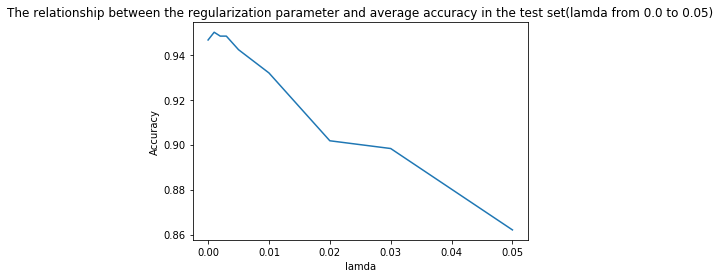

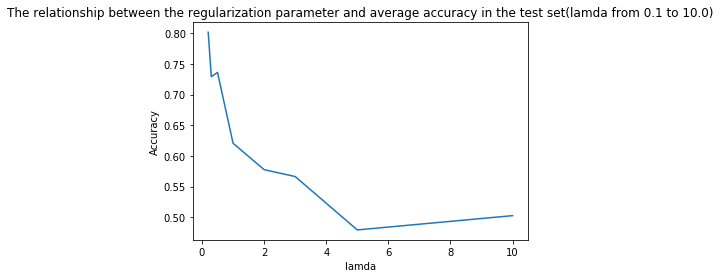

In [231]:
#draw graph
plt.title('The relationship between the regularization parameter and average accuracy in the test set(lamda from 0.0 to 0.05)')
plt.plot(lam_test[:9], predict_accuracy[:9])
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()

plt.title('The relationship between the regularization parameter and average accuracy in the test set(lamda from 0.1 to 10.0)')
plt.plot(lam_test[10:18], predict_accuracy[10:18])
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()

In order to make the results more convicing, I trained the model for ten times in each lamda and calculate the average accuracy.
From the graph we can see that when lamda is extremely small, the acuracy has better performance. The relationship basically follows the pattern that the higher of the lamda is, the lower the accuracy is. In this particular case, when lamda equals to 0.001, the model has the best performance.

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

In [255]:
eta_test = [0.01,0.05,0.1,0.5,1.0,2.0,10.0]
count = 0
nll_value = {}
for jj in eta_test:
    lr = LogReg(train_set, test_set, lam=0.001, eta=jj)
    lr.train(isVerbose=False)
    nll_value[count] = lr.test_nll
    count += 1

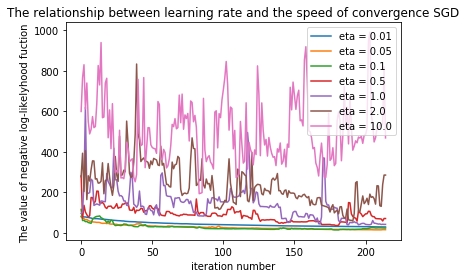

In [256]:
#draw graph
plt.title('The relationship between learning rate and the speed of convergence SGD')
count = 0
for jj in eta_test:
    plt.plot(nll_value[count])
    count += 1
plt.xlabel('iteration number')
plt.ylabel('The value of negative log-likelyhood fuction ')
plt.legend(labels=['eta = 0.01','eta = 0.05', 'eta = 0.1','eta = 0.5','eta = 1.0','eta = 2.0','eta = 10.0'],loc="best")
plt.show()

The graph indicates the relationship between learning rate and the speed of convergence. According to the convergence trend, when learning rate equals to 0.05, the model has the fastest convergence speed.
We could also draw some other conclusions here: when the learning rate is too samll, like eta = 0.01, the speed slows down; when the learning rate is too large, like eta = 0.1,0.5,1.0,2.0,10.0, the trend of convergence becomes very unstable and cannot converge at all.

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [276]:
w_sorted = np.sort(lr.w)
for i in range(0,10):
    print("Top ", i+1, "best predictors for negative class is: ", vocab[lr.w.tolist().index(w_sorted[i])], " the weight is: ",w_sorted[i])
for i in range(0,10):
    print("Top ", i+1, "best predictors for popsitive class is: ", vocab[lr.w.tolist().index(w_sorted[-(i+1)])], " the weight is: ",w_sorted[-(i+1)])
    

Top  1 best predictors for negative class is:  wrangler  the weight is:  -48.9997315302
Top  2 best predictors for negative class is:  gear  the weight is:  -47.7322474486
Top  3 best predictors for negative class is:  indiana  the weight is:  -36.8947991886
Top  4 best predictors for negative class is:  jeep  the weight is:  -24.6194916522
Top  5 best predictors for negative class is:  boole  the weight is:  -20.9553256231
Top  6 best predictors for negative class is:  lb  the weight is:  -18.8245769853
Top  7 best predictors for negative class is:  new  the weight is:  -18.6472831427
Top  8 best predictors for negative class is:  citizens  the weight is:  -18.0784149728
Top  9 best predictors for negative class is:  mother  the weight is:  -17.7419083797
Top  10 best predictors for negative class is:  thing  the weight is:  -17.7151262843
Top  1 best predictors for popsitive class is:  ca  the weight is:  34.3111217311
Top  2 best predictors for popsitive class is:  cup  the weight i

In mathematical aspect, the higher the absoluate value of a weight, the more contribution the corresponding word will make. In this case, if we can find the top 10 weights who have mixmum value and their corresponding words, the best predictors for positive class will be identified. The same thing happens to negative class, top 10 words who have minimum value will be the best predictors for negative class. In my code, I first sort the weight vector, then find the top 10 maximum and minimum weights and then find the corresponding words, which will be the best predictors.  

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [307]:
w_negative = []
w_positive = []
for j in range(len(lr.w)):
    if lr.w[j] <0:
        w_negative.append(lr.w[j])
    else:
        w_positive.append(lr.w[j])
print("There are ", len(w_negative)," negative prodictors and ", len(w_positive)," positive predictors")

w_negative_sorted = np.sort(np.array(w_negative))
w_positive_sorted = np.sort(np.array(w_positive))
#print(w_negative_sorted)
#print(w_positive_sorted)


for idx in range(len(lr.w)): # there are words who have the same weights
    if lr.w[idx] == w_negative_sorted[-1] :
        print("Top ", 1, "worst predictors for negative class is: ", vocab[idx], " the weight is: ",w_negative_sorted[-1])   
for i in range(6,10):
    print("Top ", i+1, "worst predictors for negative class is: ", vocab[lr.w.tolist().index(w_negative_sorted[-(i+1)])], " the weight is: ",w_negative_sorted[-(i+1)])
for i in range(0,10):
    print("Top ", i+1, "worst predictors for positive class is: ", vocab[lr.w.tolist().index(w_positive_sorted[i])], " the weight is: ",w_positive_sorted[i])

There are  2766  negative prodictors and  2561  positive predictors
Top  1 worst predictors for negative class is:  abominations  the weight is:  -3.46885425762e-17
Top  1 worst predictors for negative class is:  medallion  the weight is:  -3.46885425762e-17
Top  1 worst predictors for negative class is:  cimarron  the weight is:  -3.46885425762e-17
Top  1 worst predictors for negative class is:  groceries  the weight is:  -3.46885425762e-17
Top  1 worst predictors for negative class is:  fooling  the weight is:  -3.46885425762e-17
Top  1 worst predictors for negative class is:  pitiful  the weight is:  -3.46885425762e-17
Top  7 worst predictors for negative class is:  couples  the weight is:  -5.11259535123e-17
Top  8 worst predictors for negative class is:  investment  the weight is:  -1.03518687606e-16
Top  9 worst predictors for negative class is:  component  the weight is:  -1.12530706068e-16
Top  10 worst predictors for negative class is:  necessity  the weight is:  -3.5518032172

As I have explained before, in mathematical aspect, the lower the absoluate value of a weight, the less contribution the corresponding word will make. In this case, if we can find the top 10 weights who have minimum absolute value in both negative and positive classes, as well as their corresponding words, the worst predictors will be identified. In my code, I first find out all the weights in positive and negative classes, then find the top 10 weights with minimum absolute value in both classes and then find the corresponding words, which will be the worst predictors. 

